# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250411-09-54-18 - 09-54-18


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_10_locs.txt.
It is known that the shortest distance is 290.2


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 21 qubits needed for 10 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    if sdl.mode == 8:
        #input is all zeros
        unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    elif sdl.mode == 9:
        #input is 0.5
        unrepeated_input = torch.full((1,sdl.qubits), 0.5).float().to(device)

    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 21])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 21])


Set up model with gradient required:

In [11]:

model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 924 parameters in total, of which 924 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

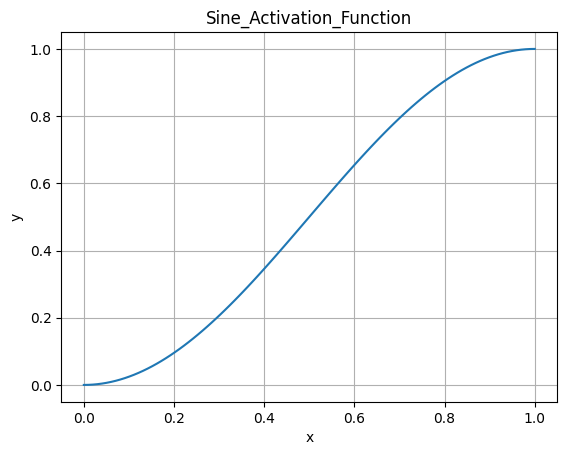

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[-0.0895, -0.0423, -0.0331,  0.2114, -0.0253,  0.0449, -0.0611, -0.0203,
          0.0839,  0.0006,  0.1375,  0.1987, -0.1788,  0.0630,  0.1029, -0.1557,
          0.2015,  0.0719, -0.0004, -0.1285, -0.1663],
        [-0.0662,  0.0921, -0.0547, -0.0092,  0.1363,  0.0905, -0.1907, -0.1982,
         -0.0520,  0.1772, -0.0675, -0.0332,  0.1272,  0.0099,  0.0051, -0.1354,
         -0.1488,  0.2049, -0.0550, -0.1362, -0.2019],
        [ 0.0203, -0.1005, -0.1699,  0.0964, -0.1583, -0.0425, -0.2138, -0.1438,
          0.0504,  0.1531,  0.1132, -0.0579, -0.1455, -0.1380, -0.0953,  0.1430,
         -0.0960, -0.0202,  0.1067,  0.1687, -0.1253],
        [-0.1845, -0.0227, -0.1724,  0.1126, -0.1027,  0.0774,  0.0591, -0.1749,
          0.0443,  0.0457,  0.0996,  0.1401,  0.0083, -0.1006,  0.0687,  0.0183,
          0.0778, -0.1321, -0.0596, -0.0923, -0.0951],
        [ 0.1958, -0.1151,  0.0158,  0.0065, -0.0225, -0.0230, -0.0723,  0.1444,
         -0.18

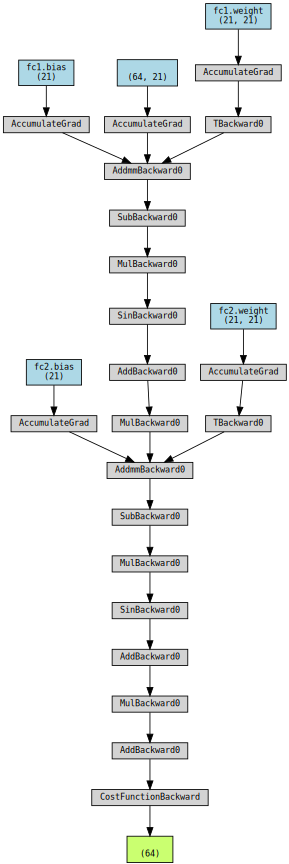

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 588.656 Epoch min cost:483.400, Lowest Cost to date: 462.900
Epoch 0, fc1.weight grad: 4152.75
Epoch 0, fc1.bias grad: 1812.41
Epoch 0, fc2.weight grad: 7083.73
Epoch 0, fc2.bias grad: 3615.89
Epoch 50, Average cost: 544.961 Epoch min cost:390.900, Lowest Cost to date: 328.700
Epoch 50, fc1.weight grad: 16399.26
Epoch 50, fc1.bias grad: 7157.22
Epoch 50, fc2.weight grad: 14600.23
Epoch 50, fc2.bias grad: 4949.19
Epoch 100, Average cost: 575.703 Epoch min cost:460.200, Lowest Cost to date: 325.000
Epoch 100, fc1.weight grad: 17557.40
Epoch 100, fc1.bias grad: 7662.68
Epoch 100, fc2.weight grad: 13663.80
Epoch 100, fc2.bias grad: 4318.67
Epoch 150, Average cost: 538.219 Epoch min cost:417.500, Lowest Cost to date: 325.000
Epoch 150, fc1.weight grad: 28846.54
Epoch 150, fc1.bias grad: 12589.66
Epoch 150, fc2.weight grad: 12671.13
Epoch 150, fc2.bias grad: 4312.74
Epoch 200, Average cost: 549.478 Epoch min cost:400.300, Lowest Cost to date: 325.000
Epoch 200, fc1.wei

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 325.000 at epoch 81.
The best known cost is 290.200


Plot loss ratio by epoch:

Graph for Run ID: 20250411-09-54-18-09-54-18 being saved to graphs\20250411-09-54-18\09-54-18.png


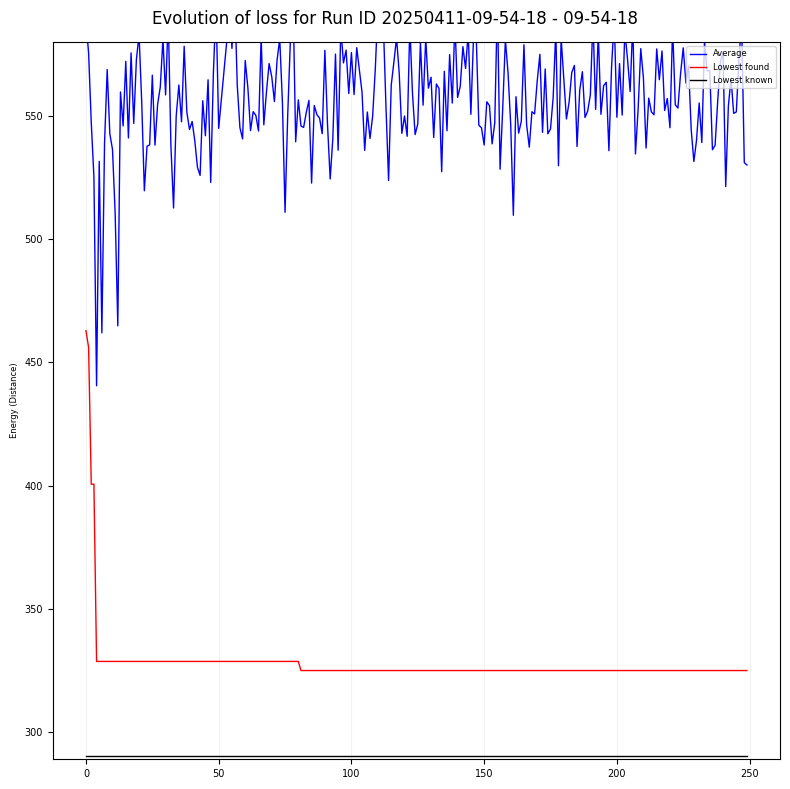

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[-3.4059, -3.3587, -3.3495, -3.1049, -3.3417, -3.2715, -3.3774, -3.3367,
         -3.2324, -3.3158, -3.1788, -3.1177, -3.4951, -3.2534, -3.2135, -3.4720,
         -3.1148, -3.2444, -3.3167, -3.4448, -3.4826],
        [-4.2494, -4.0912, -4.2380, -4.1925, -4.0470, -4.0927, -4.3740, -4.3815,
         -4.2353, -4.0061, -4.2508, -4.2165, -4.0561, -4.1734, -4.1782, -4.3187,
         -4.3321, -3.9784, -4.2383, -4.3195, -4.3852],
        [-1.5410, -1.6618, -1.7312, -1.4649, -1.7196, -1.6038, -1.7751, -1.7051,
         -1.5109, -1.4082, -1.4481, -1.6192, -1.7068, -1.6993, -1.6566, -1.4183,
         -1.6573, -1.5814, -1.4546, -1.3926, -1.6866],
        [ 8.6072,  8.7690,  8.6192,  8.9043,  8.6890,  8.8691,  8.8508,  8.6168,
          8.8360,  8.8374,  8.8913,  8.9318,  8.8000,  8.6911,  8.8604,  8.8100,
          8.8695,  8.6595,  8.7320,  8.6994,  8.6966],
        [-2.7127, -3.0236, -2.8927, -2.9020, -2.9310, -2.9315, -2.9808, -2.7642,
         -3.0934, -2.